<a href="https://colab.research.google.com/github/GR-TheArchitect/Colab_Public/blob/master/MAIR_09/MAIR_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 13.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00


In [ ]:
#preparing all libraries
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import tensorflow as tf
from tensorflow import keras

assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import pandas as pd #to use data frames
from pandas import DataFrame #dataframes
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from datasets import load_dataset

from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset, TensorDataset

#in case we switch to pytorch
import torch
import torch.nn as nn
import math

Check for a GPU in Google Colab

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


**Get the file: please note that running the full dataset with the duplicates may require a GPU. Running the dataset without duplicates does not.**

In [ ]:
#get the dialog text with duplicates
colab_url = "https://raw.githubusercontent.com/GR-TheArchitect/Colab_Public/master/MAIR_09/Dialog_Database.csv"
dialog_dataset = load_dataset("csv", data_files=colab_url, sep=";", names=['text', 'label'])

**The dataset is structured as texts and labels separated by ";". The dataset sits in the train dataset (so train refers to the full dataset not the training subset) with the dictionary shown below. we can extend this by further structuring the dialog text with three distinct datasets; namely, training, validation, and testing**

In [ ]:
print(dialog_dataset)

NameError: ignored

In [ ]:
#printing the first two dialog texts and their corresponding dialog acts.
print(dialog_dataset['train'][:2])

{'text': ['im looking for a moderately priced restaurant that serves', 'any part of town'], 'label': ['inform', 'inform']}


In [ ]:
#turn the dataset into pandas for graphing. We will reset it to a database at the end.
dialog_dataset.set_format(type="pandas")
df = dialog_dataset['train'][:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25501 entries, 0 to 25500
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25501 non-null  object
 1   label   23889 non-null  object
dtypes: object(2)
memory usage: 398.6+ KB


**Graphing the frequency of the occcurance of the dialog acts. When we use the database with duplicates, the "inform" dialog act appears 40% of the time. without duplicates; however, it appears about 57% of the time.**

Text(0.5, 1.0, 'Frequency of dialog acts in the dialog dataset (with duplicates)')

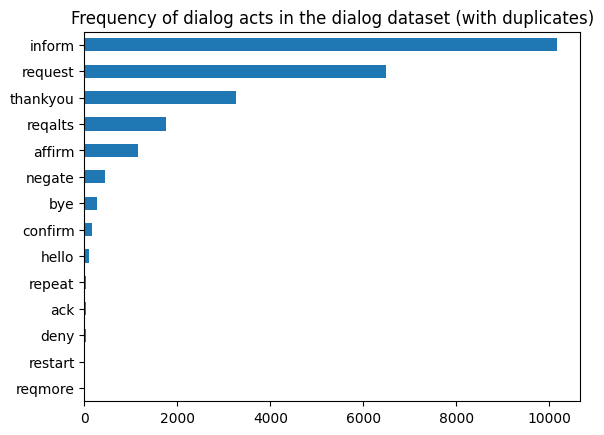

In [ ]:
df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of dialog acts in the dialog dataset (with duplicates)")

#based on this graph, inform appears about 40% of the time. However, as show later, inform appears 57% of the time in the dataset with no duplicates

In [ ]:
#reset the dataset
dialog_dataset.reset_format()

**Tokenize the dataset.**

In [ ]:
def tokenize(dataset):
  return tokenizer(dataset['text'], padding=True, truncation=True)

print(tokenize(dialog_dataset['train'][:2]))

{'input_ids': [[101, 10047, 2559, 2005, 1037, 17844, 21125, 4825, 2008, 4240, 102], [101, 2151, 2112, 1997, 2237, 102, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


In [ ]:
dialog_encoded = dialog_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/25501 [00:00<?, ? examples/s]

In [ ]:
print(dialog_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [ ]:
type(dialog_encoded)

datasets.dataset_dict.DatasetDict

**Hot-encode the labels and append them to the dataset**

In [ ]:
label_to_int = {label: i for i, label in enumerate(set(dialog_encoded['train']['label']))}
num_classes = len(label_to_int)
print(num_classes)
print(label_to_int)

15
{'negate': 0, 'ack': 1, 'hello': 2, 'inform': 3, 'reqmore': 4, 'repeat': 5, None: 6, 'bye': 7, 'request': 8, 'restart': 9, 'reqalts': 10, 'confirm': 11, 'deny': 12, 'affirm': 13, 'thankyou': 14}


In [ ]:
# Map your labels to integers using the dictionary
int_labels = [label_to_int[label] for label in dialog_encoded['train']['label']]
int_labels[:10]


[3, 3, 3, 11, 13, 8, 14, 3, 3, 8]

In [ ]:
# Convert the integer labels to one-hot encoding
one_hot_labels = tf.one_hot(int_labels, depth=num_classes)
one_hot_labels[:4]

<tf.Tensor: shape=(4, 15), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices((dialog_encoded['train'][:21675]['text'], one_hot_labels[:21675]))
testing_dataset = tf.data.Dataset.from_tensor_slices((dialog_encoded['train'][21675:]['text'], one_hot_labels[21675:]))

In [ ]:
BATCH_SIZE = 64
training_dataset = training_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in training_dataset.take(1):
  print('Input_id: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


Input_id:  [b'im looking for a moderately priced restaurant that serves'
 b'any part of town' b'bistro food']

labels:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
for example, label in testing_dataset.take(1):
  print('Input_id: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

Input_id:  [b'type of food does it serve' b'type of food does it serve'
 b'i would like modern european food']

labels:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder.adapt(training_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'food', 'you', 'thank', 'bye', 'good',
       'number', 'restaurant', 'phone', 'of', 'address', 'i', 'a', 'town',
       'what', 'in', 'is', 'part'], dtype='<U16')

In [ ]:
# Creating the model
model = tf.keras.Sequential([encoder,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,
# Use masking to handle the variable sequence lengths
mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(15, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

In [ ]:
# Training the model
history = model.fit(training_dataset, epochs=10, validation_data=testing_dataset, validation_steps=30)

Epoch 1/10
339/339 [==============================] - 26s 37ms/step - loss: 2.1435 - accuracy: 0.5947 - val_loss: 1.4231 - val_accuracy: 0.7505
Epoch 2/10
339/339 [==============================] - 3s 10ms/step - loss: 0.9819 - accuracy: 0.7875 - val_loss: 0.8186 - val_accuracy: 0.8214
Epoch 3/10
339/339 [==============================] - 3s 9ms/step - loss: 0.6122 - accuracy: 0.8657 - val_loss: 0.5825 - val_accuracy: 0.8755
Epoch 4/10
339/339 [==============================] - 3s 9ms/step - loss: 0.4365 - accuracy: 0.9164 - val_loss: 0.4183 - val_accuracy: 0.9187
Epoch 5/10
339/339 [==============================] - 3s 9ms/step - loss: 0.3072 - accuracy: 0.9409 - val_loss: 0.2886 - val_accuracy: 0.9438
Epoch 6/10
339/339 [==============================] - 3s 9ms/step - loss: 0.2258 - accuracy: 0.9505 - val_loss: 0.2149 - val_accuracy: 0.9474
Epoch 7/10
339/339 [==============================] - 3s 9ms/step - loss: 0.1797 - accuracy: 0.9552 - val_loss: 0.1727 - val_accuracy: 0.9563
Epo

In [ ]:
# Test the model on the testing data
test_loss, test_acc, test_precision, test_recall, test_f1score = model.evaluate(testing_dataset)

60/60 [==============================] - 0s 4ms/step - loss: 0.1064 - accuracy: 0.9726


In [ ]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Recall:', test_recall)
print('Test Precision:', test_precision)
print('Test F1-score:', test_f1score)

Test Loss: 0.10635317862033844
Test Accuracy: 0.9725561738014221


In [ ]:
# Create a helper function to plot graphs
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 2.2452156163752077)

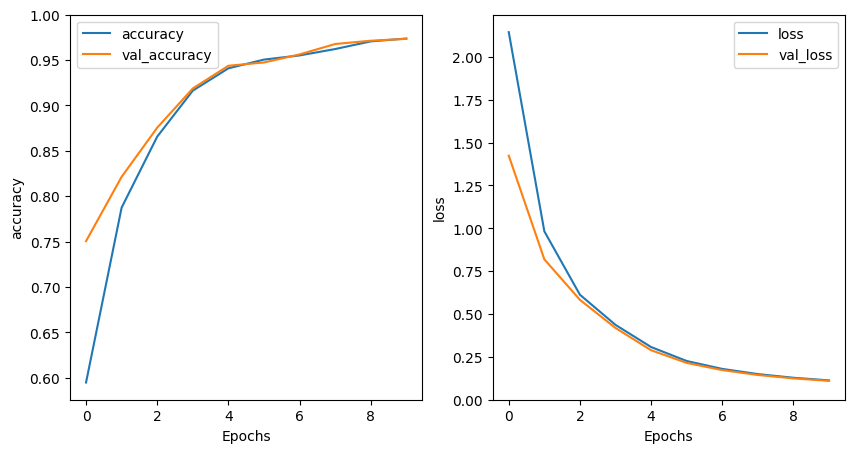

In [ ]:
# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

This below splitting is unnecessary at this point but I'll keep because we may still use for enhancement purposes.
**Split the full dailog text into training and testing. To verify that the splitting works correctly we may need to turn shuffling off.**

In [ ]:
#may not be needed#################
X_train, X_test, y_train, y_test = train_test_split(dialog_dataset['train']['text'],dialog_dataset['train']['label']
                                                    , random_state=104,test_size=0.15, shuffle=False)
######################################

In [ ]:
####################################################
X_train, X_test, y_train, y_test = train_test_split(dialog_encoded['train']['text'],dialog_encoded['train']['label']
                                                    , random_state=104,test_size=0.15, shuffle=False)
#########################################################

In [ ]:
######################################################################
X_train, X_test, y_train, y_test = train_test_split(dialog_encoded['train']['text'],dialog_encoded['train']['label']
                                                    , random_state=104,test_size=0.15, shuffle=False)
##########################################################################333

**Verify that the splitting is done correctly.**

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

21675 3826 21675 3826


In [ ]:
print(X_train[:2], y_train[:2])
print(X_train[21673:21675], y_train[21673:21675])

['im looking for a moderately priced restaurant that serves', 'any part of town'] ['inform ', 'inform ']
['no', 'expensive'] ['negate ', 'inform ']


In [ ]:
print(X_test[:2], y_test[:2])
print(X_test[3824:3826], y_test[3824:3826])

['type of food does it serve', 'type of food does it serve'] ['request ', 'request ']
['whats the address and phone number', 'thank you good bye'] ['request ', 'thankyou ']


**Switch to the dataset with no duplicates**
********
********
********

Get the file

In [ ]:
#we can split the data from here but we're not. we'll see what's more efficient###########
colab_url = "https://raw.githubusercontent.com/GR-TheArchitect/Colab_Public/master/MAIR_09/Dialog_Database_NoDuplicates.csv"
train_dataset, test_dataset = load_dataset("csv", data_files=colab_url, sep=";", names=['text', 'label'], split=["train[:85%]", "train[85%:]"])
########################################

In [ ]:
colab_url = "https://raw.githubusercontent.com/GR-TheArchitect/Colab_Public/master/MAIR_09/Dialog_Database_NoDuplicates.csv"
dialog_dataset_nodup = load_dataset("csv", data_files=colab_url, sep=";", names=['text', 'label'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#turn the dataset into pandas for graphing. We will reset it to a database at the end.
dialog_dataset_nodup.set_format(type="pandas")
df = dialog_dataset_nodup['train'][:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5359 entries, 0 to 5358
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5359 non-null   object
 1   label   5110 non-null   object
dtypes: object(2)
memory usage: 83.9+ KB


Text(0.5, 1.0, 'Frequency of dialog acts in the dialog dataset (without duplicates)')

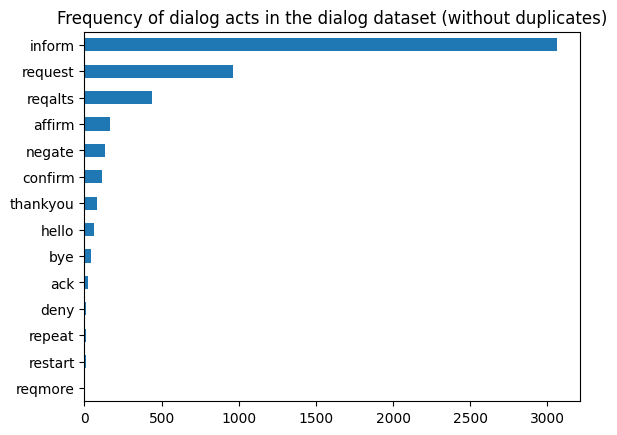

In [ ]:
df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of dialog acts in the dialog dataset (without duplicates)")

In [ ]:
#reset the dataset
dialog_dataset_nodup.reset_format()

In [ ]:
dialog_encoded_nodup = dialog_dataset_nodup.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/5359 [00:00<?, ? examples/s]

In [ ]:
label_to_int = {label: i for i, label in enumerate(set(dialog_encoded_nodup['train']['label']))}
num_classes = len(label_to_int)
print(num_classes)
print(label_to_int)

15
{'restart': 0, 'negate': 1, 'confirm': 2, 'reqmore': 3, 'bye': 4, 'affirm': 5, 'thankyou': 6, 'reqalts': 7, 'ack': 8, 'inform': 9, 'hello': 10, 'deny': 11, 'request': 12, 'repeat': 13, None: 14}


In [ ]:
# Map your labels to integers using the dictionary
int_labels = [label_to_int[label] for label in dialog_encoded_nodup['train']['label']]
int_labels[:10]

[9, 9, 9, 2, 5, 12, 6, 9, 9, 12]

In [ ]:
# Convert the integer labels to one-hot encoding
one_hot_labels = tf.one_hot(int_labels, depth=num_classes)
one_hot_labels[:4]

<tf.Tensor: shape=(4, 15), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
training_dataset_nodup = tf.data.Dataset.from_tensor_slices((dialog_encoded_nodup['train'][:4555]['text'], one_hot_labels[:4555]))
testing_dataset_nodup = tf.data.Dataset.from_tensor_slices((dialog_encoded_nodup['train'][4555:]['text'], one_hot_labels[4555:]))

In [ ]:
BATCH_SIZE = 64
training_dataset_nodup = training_dataset_nodup.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testing_dataset_nodup = testing_dataset_nodup.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in training_dataset_nodup.take(1):
  print('Input_id: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


Input_id:  [b'im looking for a moderately priced restaurant that serves'
 b'any part of town' b'bistro food']

labels:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
encoder_nodup = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder_nodup.adapt(training_dataset_nodup.map(lambda text, label: text))

In [ ]:
vocab_nodup = np.array(encoder_nodup.get_vocabulary())
vocab_nodup[:20]

array(['', '[UNK]', 'the', 'food', 'restaurant', 'a', 'of', 'in', 'i',
       'town', 'for', 'looking', 'part', 'im', 'that', 'serves', 'and',
       'address', 'number', 'phone'], dtype='<U16')

In [ ]:
# Creating the model
model_nodup = tf.keras.Sequential([encoder_nodup,tf.keras.layers.Embedding(input_dim=len(encoder_nodup.get_vocabulary()),output_dim=64,
# Use masking to handle the variable sequence lengths
mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(15, activation='softmax')
])

In [ ]:
model_nodup.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

In [ ]:
# Training the model
history_nodup = model_nodup.fit(training_dataset_nodup, epochs=10, validation_data=testing_dataset_nodup, validation_steps=30)

Epoch 1/10
71/72 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.8378

72/72 [==============================] - 1s 12ms/step - loss: 0.5150 - accuracy: 0.8378 - val_loss: 0.5226 - val_accuracy: 0.8346
Epoch 2/10
72/72 [==============================] - 1s 8ms/step - loss: 0.4940 - accuracy: 0.8435
Epoch 3/10
72/72 [==============================] - 1s 9ms/step - loss: 0.4739 - accuracy: 0.8503
Epoch 4/10
72/72 [==============================] - 1s 9ms/step - loss: 0.4548 - accuracy: 0.8586
Epoch 5/10
72/72 [==============================] - 1s 9ms/step - loss: 0.4370 - accuracy: 0.8678
Epoch 6/10
72/72 [==============================] - 1s 9ms/step - loss: 0.4206 - accuracy: 0.8749
Epoch 7/10
72/72 [==============================] - 1s 9ms/step - loss: 0.4056 - accuracy: 0.8804
Epoch 8/10
72/72 [==============================] - 1s 9ms/step - loss: 0.3918 - accuracy: 0.8843
Epoch 9/10
72/72 [==============================] - 1s 9ms/step - loss: 0.3791 - accuracy: 0.8885
Epoch 10/10
72/72 [==============================] - 1s 8ms/step - loss: 0.3671 - accu

In [ ]:
# Test the model on the testing data
test_loss, test_acc, test_precision, test_recall, test_f1score = model_nodup.evaluate(testing_dataset_nodup)

13/13 [==============================] - 0s 5ms/step - loss: 0.3970 - accuracy: 0.8781


In [ ]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Recall:', test_recall)
print('Test Precision:', test_precision)
print('Test F1-score:', test_f1score)

Test Loss: 0.39703115820884705
Test Accuracy: 0.8781094551086426


(0.0, 0.5303948312997818)

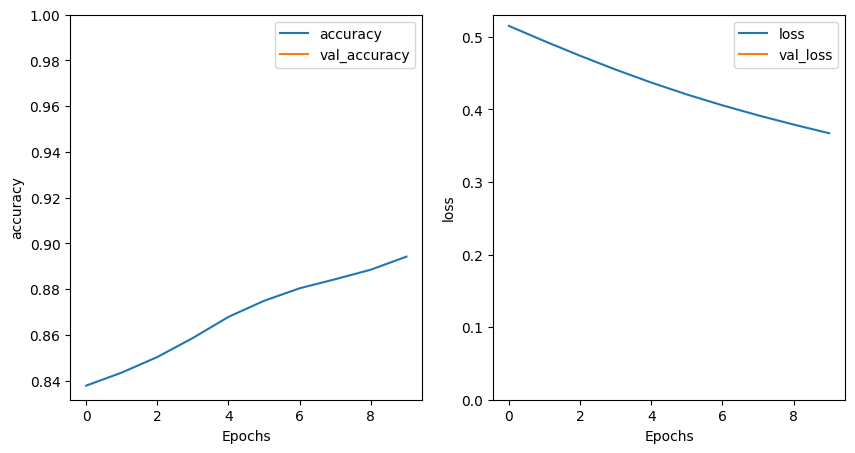

In [ ]:
# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history_nodup, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_nodup, 'loss')
plt.ylim(0, None)